In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

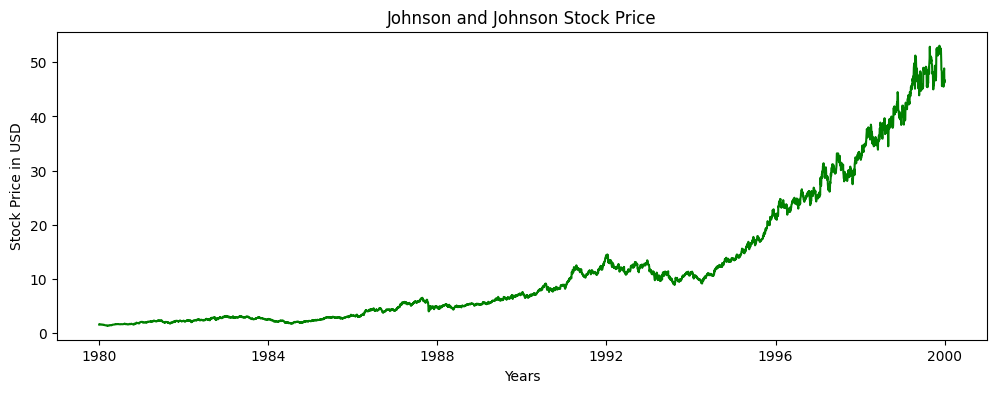

In [3]:
df_jnj=pd.read_csv('JNJ.csv')
df_jnj['Date']=pd.to_datetime(df_jnj['Date'],format="%Y-%m-%d")
df_chunk=df_jnj[(df_jnj['Date']>='1980-01-01')&(df_jnj['Date']<'2000-01-01')].reset_index(drop=True)
plt.figure(figsize=(12,4))
plt.plot(df_chunk['Date'],df_chunk['Close'],'g')
plt.ylabel('Stock Price in USD')
plt.xlabel('Years')
plt.title('Johnson and Johnson Stock Price')
plt.show()

## Quaterly data

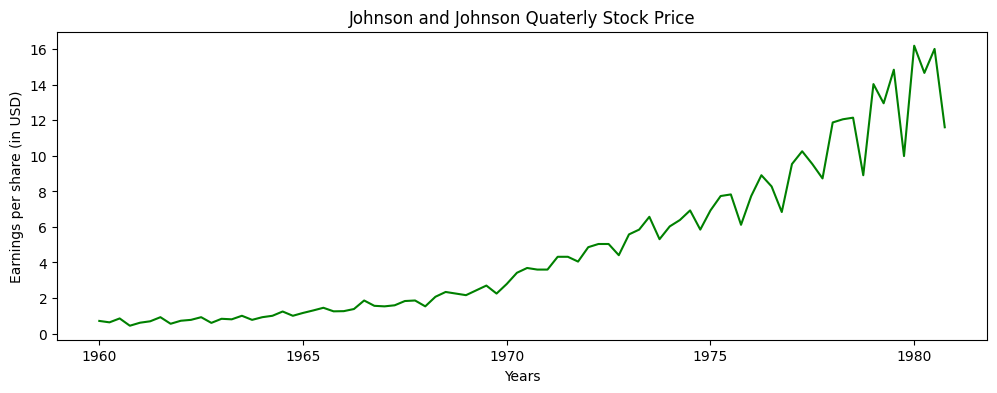

In [4]:
df_jnj=pd.read_csv('JNJ_q.csv')
plt.figure(figsize=(12,4))
plt.plot(df_jnj['time'],df_jnj['value'],'g')
plt.ylabel('Earnings per share (in USD)')
plt.xlabel('Years')
plt.title('Johnson and Johnson Quaterly Stock Price')
plt.show()

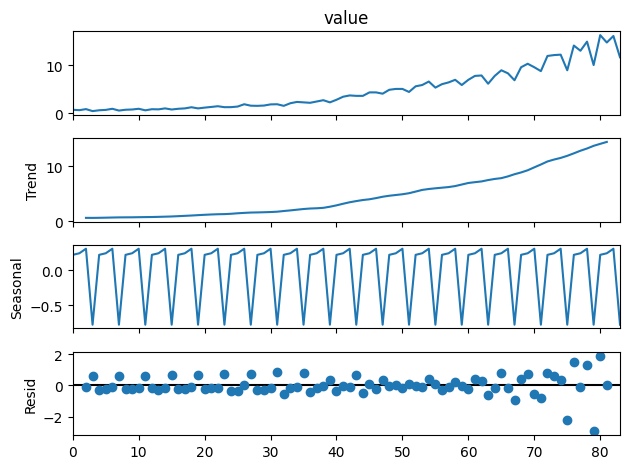

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_jnj['value'], model='additive', period=4)
result.plot()
plt.show()

In [6]:
import numpy as np
def MAPE(true,pred):
    return np.mean(np.abs(pred-true)/np.abs(true)*100)

In [7]:
train=df_jnj[:-4]
test=df_jnj[-4:]
test['forecast_mean']=train['value'].mean()
test['forecast_mean_last_season']=train[-4:]['value'].mean()
test['forecast_last_value']=train[-1:]['value'].values[0]
test['forecast_last_season']=train[-4:]['value'].values
print('MAPE for Forecasting using:')
print(f"  a. Mean of 1960 to 1979: {MAPE(test['value'],test['forecast_mean']) :.2f}")
print(f"  b. Using the last value: {MAPE(test['value'],test['forecast_last_value']) :.2f}")
print(f"  c. Mean of 1979 year: {MAPE(test['value'],test['forecast_mean_last_season']) :.2f}")
print(f"  d. Using last Season or quarter: {MAPE(test['value'],test['forecast_last_season']) :.2f}")

MAPE for Forecasting using:
  a. Mean of 1960 to 1979: 70.01
  b. Using the last value: 30.46
  c. Mean of 1979 year: 15.60
  d. Using last Season or quarter: 11.56


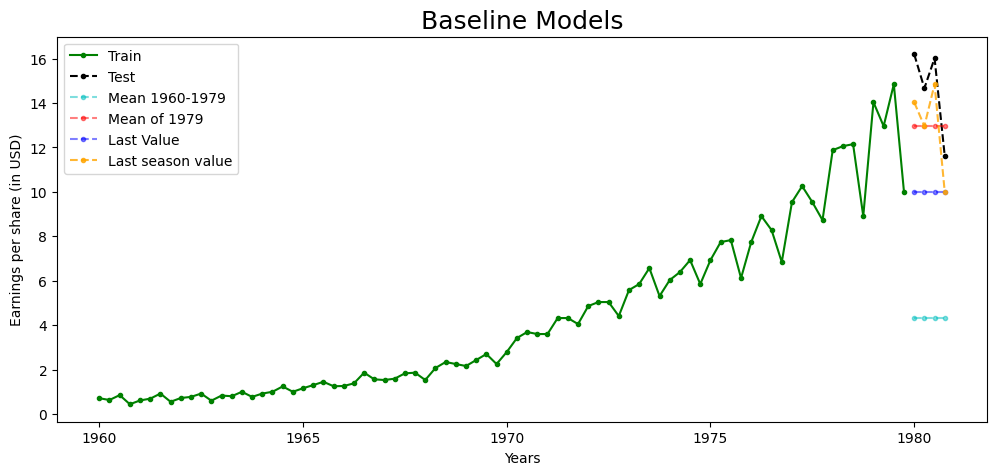

In [8]:
plt.figure(figsize=(12,5))
plt.plot(train['time'],train['value'],'g',marker='.')
plt.plot(test['time'],test['value'],'k--.')
plt.plot(test['time'],test['forecast_mean'],'c--.',alpha=0.5)
plt.plot(test['time'],test['forecast_mean_last_season'],'r--.',alpha=0.5)
plt.plot(test['time'],test['forecast_last_value'],'b--.',alpha=0.5)
plt.plot(test['time'],test['forecast_last_season'],'--.',color='orange',alpha=0.8)
plt.legend(['Train','Test','Mean 1960-1979','Mean of 1979','Last Value','Last season value'])
plt.ylabel('Earnings per share (in USD)')
plt.xlabel('Years')
plt.title('Baseline Models',fontsize=18)
plt.show()

## Google

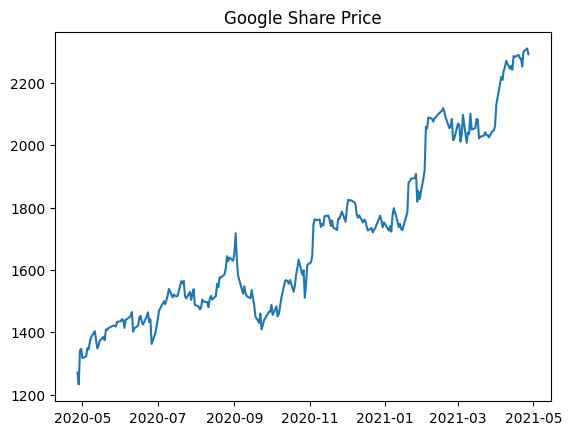

In [9]:
df_g=pd.read_csv('GOOGL.csv')
df_g['Date']=pd.to_datetime(df_g['Date'],format='%Y-%m-%d')
plt.plot(df_g['Date'],df_g['Close'])
plt.title('Google Share Price')
plt.show()

In [10]:
result = adfuller(df_g['Close'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: 0.1602504866477145
p-value: 0.9699419435913058


In [11]:
diff_googl=np.diff(df_g['Close'], n=1)
result = adfuller(diff_googl)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -5.303439704295221
p-value: 5.386530961454919e-06


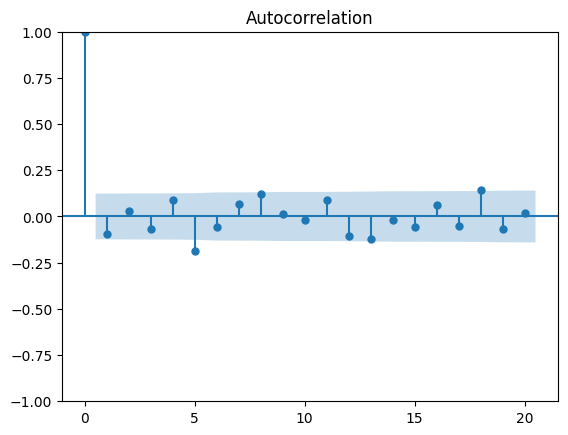

In [12]:
plot_acf(diff_googl, lags=20)
plt.show()

Text(0.5, 1.0, 'First order Differencing')

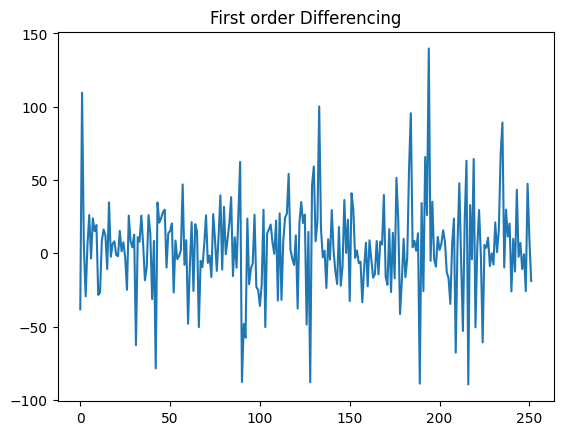

In [13]:
plt.plot(diff_googl)
plt.title('First order Differencing')

For modelling google share prices. we can see there is no autocorrelation with lags for stationary data. Thus we will have to use ony of the baseline models.

## MA Models

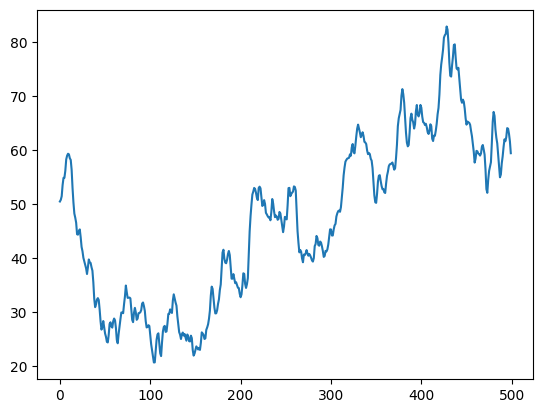

In [14]:
df_widget=pd.read_csv('widget_sales.csv')
plt.plot(df_widget['widget_sales'])
plt.show()

In [15]:
diff_widget=np.diff(df_widget['widget_sales'],n=1)
result = adfuller(diff_widget)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -10.576657780341952
p-value: 7.076922818587599e-19


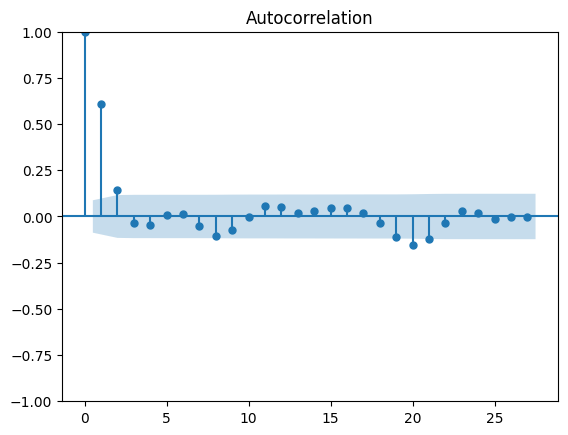

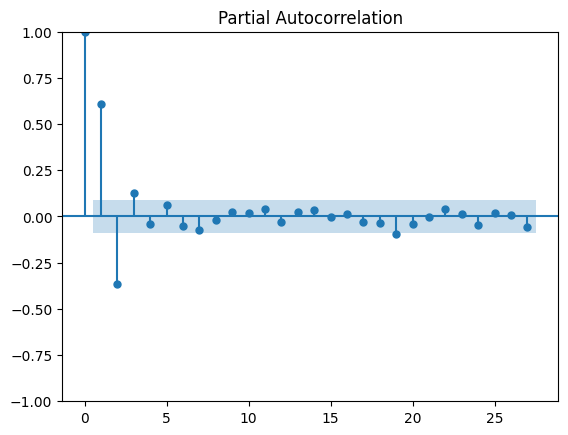

In [16]:
plot_acf(diff_widget)
plot_pacf(diff_widget) # We can see some sinosoidal nature. so we ignore AR part
plt.show()

It is MA(2). So we use a window size of 2. we can use window size less than or equal to order of MA process

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df,train_len,pred_len,window,method='mean',p=2,q=2):
    predictions=[]
    tot_len=train_len+pred_len
    if method=='mean':
        for i in range(train_len,tot_len,window):
            mean_window=df[:i].mean()[0]
            predictions.extend(mean_window for _ in range(window))
        return predictions
    if method=='last':
        for i in range(train_len,tot_len,window):
            last_ele=df[:i].iloc[-1].values[0]
            predictions.extend(last_ele for _ in range(window))
        return predictions
    if method=='MA':
        for i in range(train_len,tot_len,window):
            data_window=df[:i]
            model = SARIMAX(data_window, order=(0,0,q))
            res = model.fit(disp=False)
            pred = res.get_prediction(0, i + window - 1)
            oos_pred = pred.predicted_mean.iloc[-window:]
            predictions.extend(oos_pred)
        return predictions
    if method=='AR':
        for i in range(train_len,tot_len,window):
            data_window=df[:i]
            model = SARIMAX(data_window, order=(p,0,0))
            res = model.fit(disp=False)
            pred = res.get_prediction(0, i + window - 1)
            oos_pred = pred.predicted_mean.iloc[-window:]
            predictions.extend(oos_pred)
        return predictions

In [18]:
df_diff=pd.DataFrame({'widget_sales_difference':diff_widget})
train=df_diff[:449]
test=df_diff[449:]

In [19]:
test['mean']=rolling_forecast(df_diff,len(train),len(test),2,'mean',q=2)
test['last']=rolling_forecast(df_diff,len(train),len(test),2,'last',q=2)
test['MA']=rolling_forecast(df_diff,len(train),len(test),2,'MA',q=2)

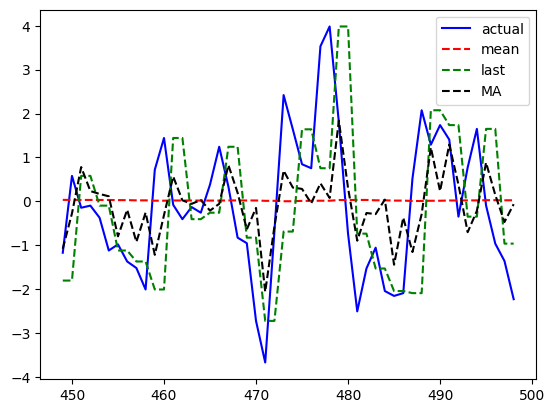

In [20]:
plt.plot(test['widget_sales_difference'],'b')
plt.plot(test['mean'],'r--')
plt.plot(test['last'],'g--')
plt.plot(test['MA'],'k--')
plt.legend(['actual','mean','last','MA'])
plt.show()

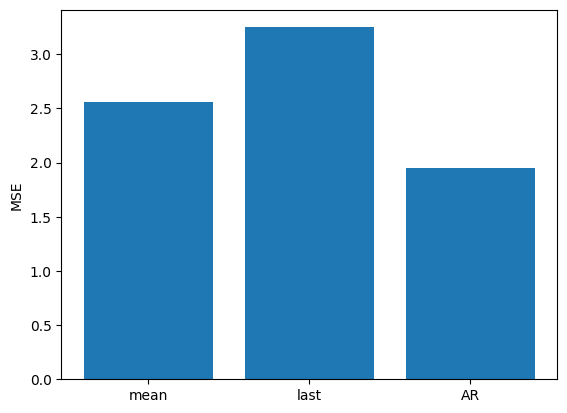

In [21]:
from sklearn.metrics import mean_squared_error

plt.bar(x=['mean','last','AR'],height=(mean_squared_error(test['widget_sales_difference'],test['mean']),mean_squared_error(test['widget_sales_difference'],test['last']),mean_squared_error(test['widget_sales_difference'],test['MA'])))
plt.ylabel('MSE')
plt.show()

In [22]:
df_widget['pred_widget_sales']=np.nan
df_widget['pred_widget_sales'][450:] = df_widget['widget_sales'].iloc[450] + test['MA'].values.cumsum() # Reversing differencing Operation

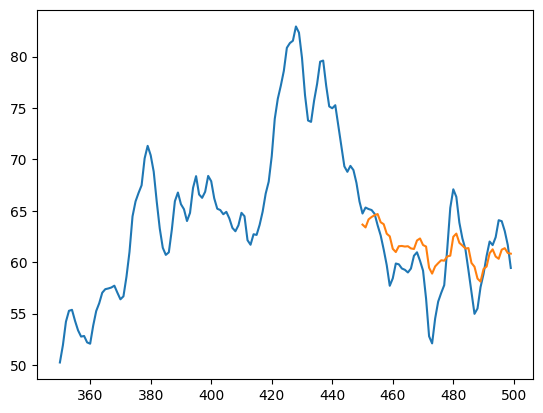

In [23]:
plt.plot(df_widget.loc[350:])

## AR Process

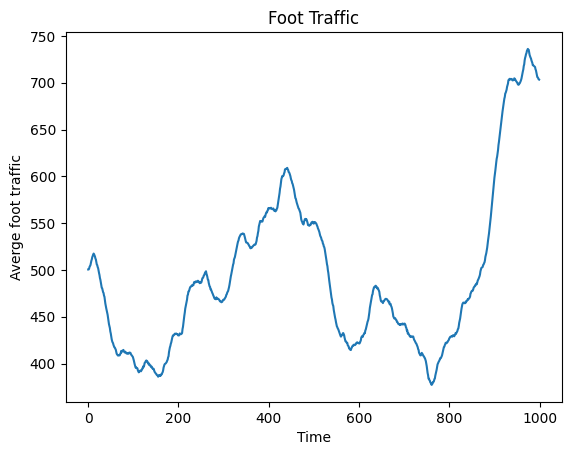

In [24]:
df_traffic=pd.read_csv('foot_traffic.csv')
plt.plot(df_traffic)
plt.title('Foot Traffic')
plt.ylabel('Averge foot traffic')
plt.xlabel('Time')
plt.show()

In [25]:
diff_traffic=np.diff(df_traffic['foot_traffic'],n=1) # Do after checking normal timeseries is stationary or not
result = adfuller(diff_traffic)  
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -5.268231347422029
p-value: 6.369317654781772e-06


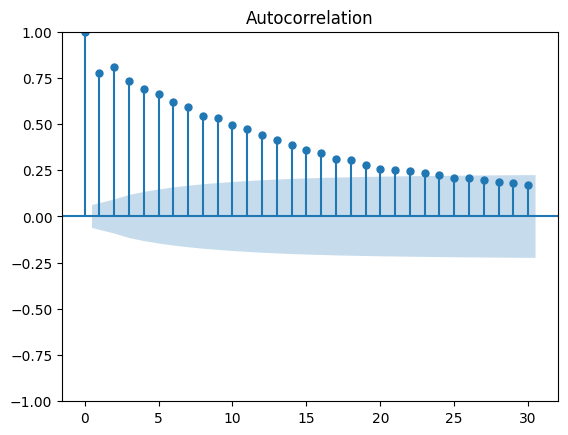

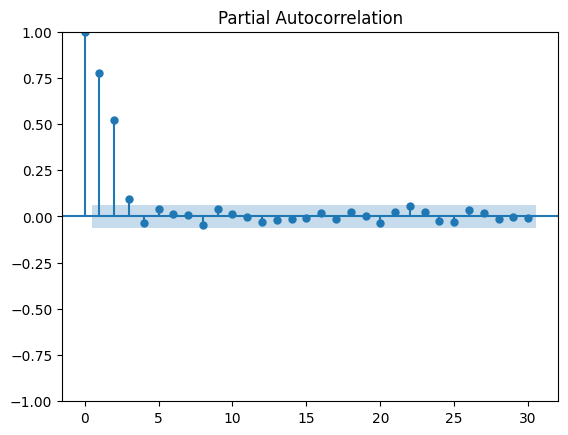

In [26]:
plot_acf(diff_traffic)
plot_pacf(diff_traffic)
plt.show()

**We can see that ACF is dying exponenetially and PACF is significant only till lag=2. SO its a AR model with p=2**

In [27]:
df_diff=pd.DataFrame({'diff_traffic':diff_traffic})
train=df_diff[:900]
test=df_diff[900:]


In [28]:
test['AR']=rolling_forecast(df_diff,len(train),len(test),1,'AR',p=2)
test['mean']=rolling_forecast(df_diff,len(train),len(test),1,'mean')
test['last']=rolling_forecast(df_diff,len(train),len(test),1,'last')

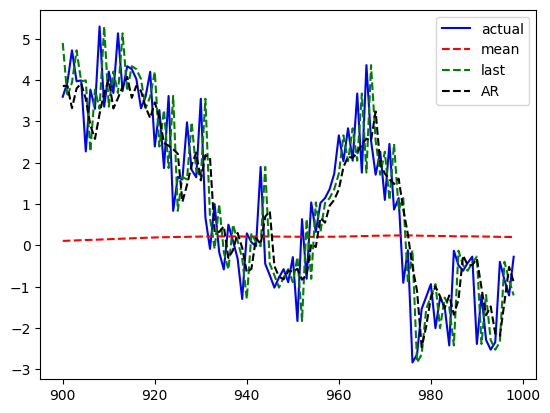

In [29]:
plt.plot(test['diff_traffic'],'b')
plt.plot(test['mean'],'r--')
plt.plot(test['last'],'g--')
plt.plot(test['AR'],'k--')
plt.legend(['actual','mean','last','AR'])
plt.show()

In [30]:
df_traffic.loc[901][0]+test['AR'].cumsum().values

array([605.98060445, 609.84951321, 613.17266007, 616.97171315,
       620.89697961, 624.44254151, 627.35353737, 629.93233254,
       633.11831204, 636.81478325, 640.82435748, 644.13986408,
       647.70720127, 651.55032893, 655.62878781, 659.20172365,
       663.06700181, 666.80619096, 670.15258814, 673.23544351,
       676.6960042 , 679.791557  , 682.26815373, 684.68348043,
       687.01262377, 689.22996631, 690.28293942, 691.74537393,
       693.68914459, 695.93594444, 697.51044397, 699.69618007,
       701.81977723, 702.14226242, 702.46921097, 702.93013237,
       702.6261354 , 702.5082971 , 702.81037702, 702.74758643,
       702.09858875, 701.52980053, 701.71074273, 701.74348397,
       702.4403178 , 703.26794637, 702.76501338, 702.00686716,
       701.18568229, 700.5674714 , 699.93644149, 699.36734954,
       698.53806662, 697.81738897, 697.85032902, 697.81179153,
       698.47668427, 699.02767692, 699.98913313, 701.09241325,
       702.44838403, 704.3452385 , 706.49545216, 708.61

In [31]:
df_traffic['pred_AR_2']=np.nan
df_traffic['pred_last_val']=np.nan
df_traffic['pred_AR_2'][len(train)+1:]=df_traffic.loc[len(train)+1][0]+test['AR'].cumsum().values
df_traffic['pred_last_val'][len(train)+1:]=df_traffic.loc[len(train)+1][0]+test['last'].cumsum().values

In [32]:
mean_squared_error(df_traffic['foot_traffic'].loc[len(train)+1:],df_traffic['pred_AR_2'].loc[len(train)+1:]),mean_squared_error(df_traffic['foot_traffic'].loc[len(train)+1:],df_traffic['pred_last_val'].loc[len(train)+1:])

(9.87768945458538, 59.883030040102135)

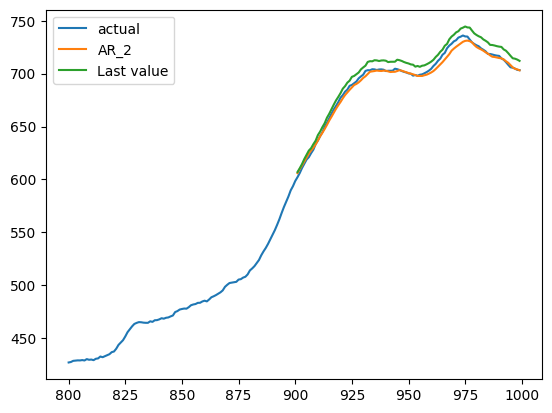

In [33]:
plt.plot(df_traffic.loc[800:])
plt.legend(['actual','AR_2','Last value'])
plt.show()

## ARMA Model

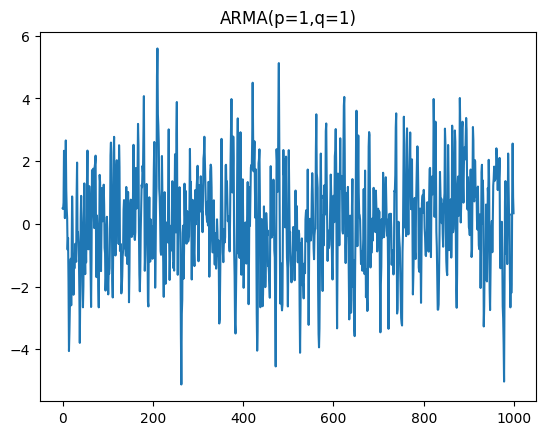

In [34]:
from statsmodels.tsa.arima_process import ArmaProcess
np.random.seed(42)
# Remember that the first coefficient is always 1 as specified by the documentation
#y(t) = 0.33y(t)–1 + 0.9e(t) –1 + e(t)
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])
arma_11_data = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)
plt.plot(arma_11_data)
plt.title('ARMA(p=1,q=1)')
plt.show()

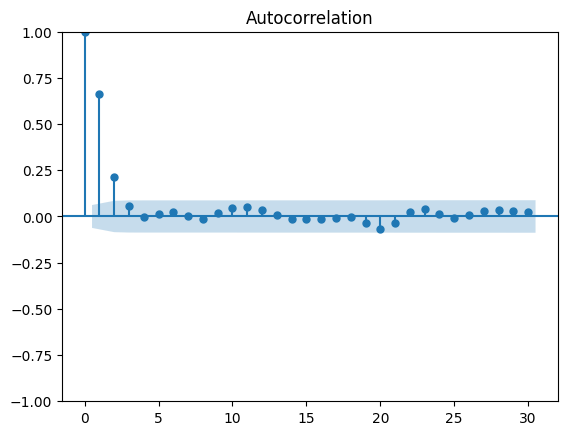

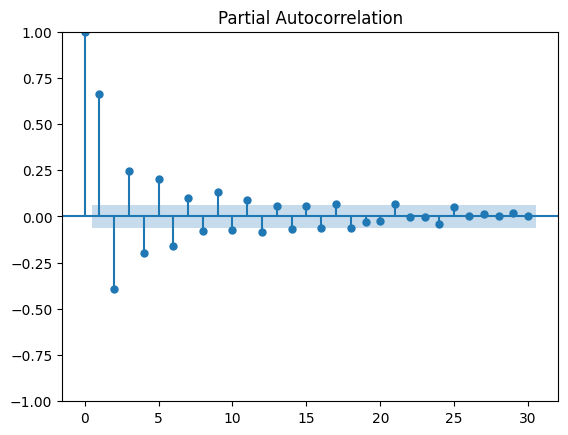

In [35]:
plot_acf(arma_11_data)
plot_pacf(arma_11_data)
plt.show()

We cannot infer ARMA models order from ACF and PACF plots. Thus we use auto_arima or custom function and use **AIC or BIC scores**.

In [36]:
def optimise_ARIMA(data):
    results=pd.DataFrame({'p':[],'q':[],'AIC':[]})
    for p in range(0,4,1):
        for q in range(0,4,1):
            try:
                model = SARIMAX(data, order=(p, 0, q),simple_differencing=False).fit(disp=False)
            except:
                continue
            aic = model.aic
            results.loc[len(results)]=[p,q,aic]
    results=results.sort_values('AIC',ascending=True).reset_index(drop=True)
    return results

In [37]:
optimise_ARIMA(arma_11_data).head()

,p,q,AIC
0,1.0,1.0,2801.407785
1,2.0,1.0,2802.906070
2,1.0,2.0,2802.967762
3,0.0,3.0,2803.666793
4,1.0,3.0,2804.524027


In [38]:
model= SARIMAX(arma_11_data, order=(1, 0, 1),simple_differencing=False).fit(disp=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1397.704
Date:                Fri, 12 Jan 2024   AIC                           2801.408
Time:                        10:54:59   BIC                           2816.131
Sample:                             0   HQIC                          2807.004
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3103      0.032      9.572      0.000       0.247       0.374
ma.L1          0.9203      0.014     66.415      0.000       0.893       0.948
sigma2         0.9560      0.042     22.825      0.000       0.874       1.038
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.97
Prob(Q):                              0.85   Prob(JB):                         0.23
Heteroskedasticity (H):               1.03   Skew:                             0.13
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
residuals=model.predict()-arma_11_data

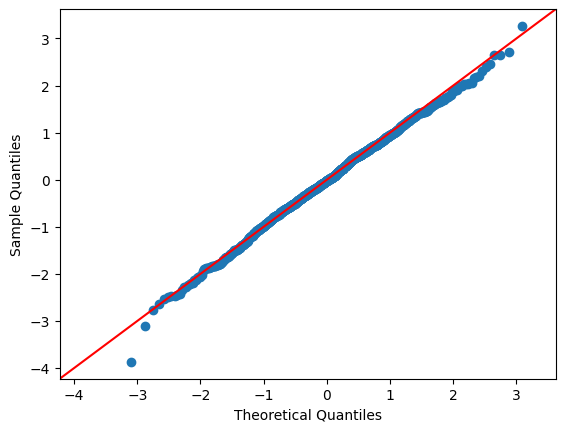

In [40]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45')
plt.show()

In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox
"""
Apply the Ljung-Box test onthe residuals, on 10 lags.

The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, the
null hypothesis cannot be rejected, meaning that the residuals are independently distributed
and uncorrelated.
"""
acorr_ljungbox(residuals, np.arange(1, 11, 1)) 

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


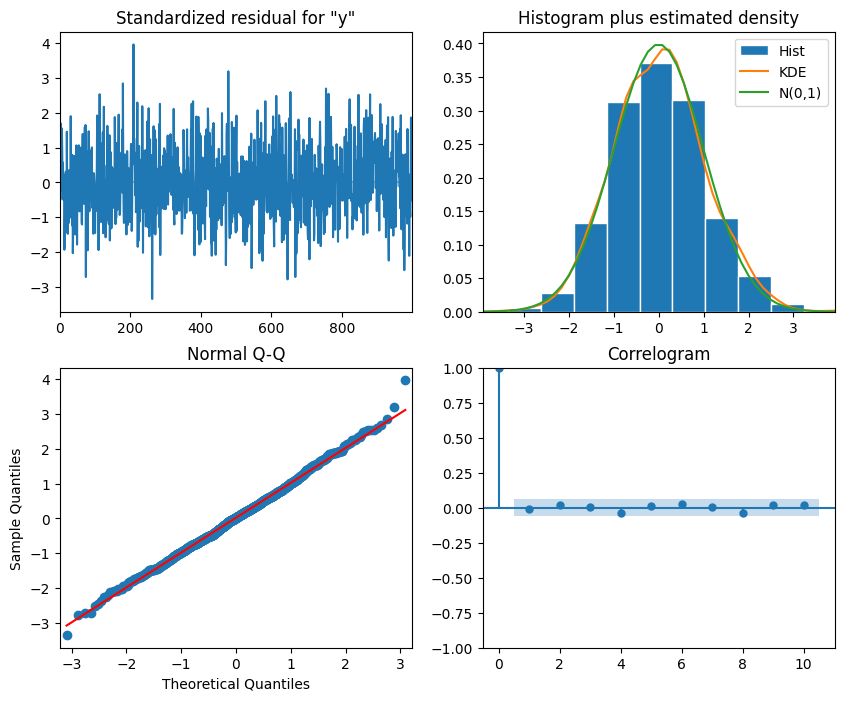

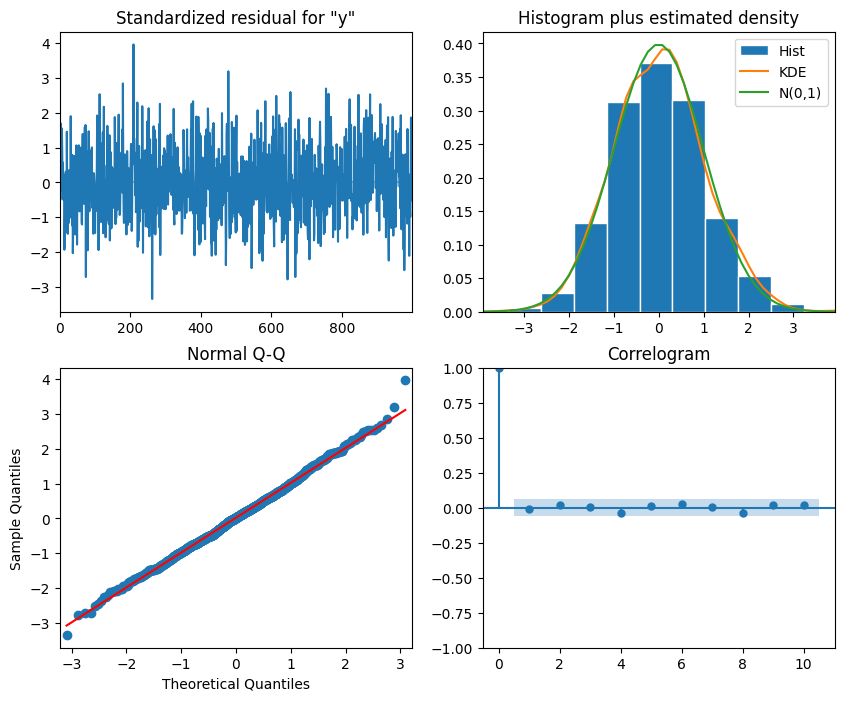

In [42]:
model.plot_diagnostics(figsize=(10,8))

## SARIMA

In [43]:
df_drug=pd.read_csv('AusAntidiabeticDrug.csv')
df_drug['ds']=pd.to_datetime(df_drug['ds'],format='%Y-%m-%d')

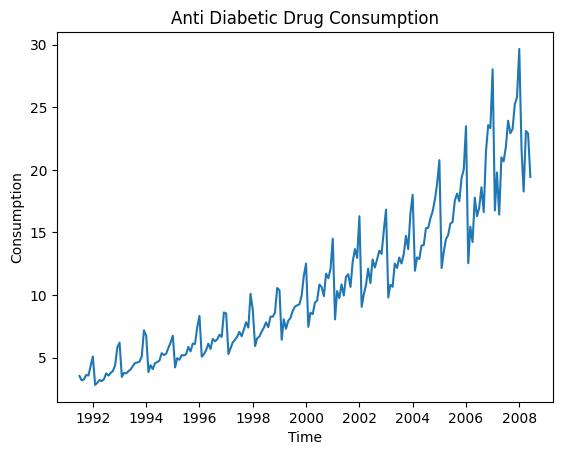

In [44]:
plt.title('Anti Diabetic Drug Consumption')
plt.ylabel('Consumption')
plt.xlabel('Time')
plt.plot(df_drug['ds'],df_drug['y'])
plt.show()

In [45]:
print('Original Data:')
results=adfuller(df_drug['y'])
print('ADF-Value:',results[0])
print('P-Value:',results[1])

print('------------\nDifference=1:')
results=adfuller(np.diff(df_drug['y'],n=1))
print('ADF-Value:',results[0])
print('P-Value:',results[1])
print('------------\nDifference=12:')
results=adfuller(np.diff(df_drug['y'],n=12))
print('ADF-Value:',results[0])
print('P-Value:',results[1])

Original Data:
ADF-Value: 3.145185689306736
P-Value: 1.0
------------
Difference=1:
ADF-Value: -2.4951721474496935
P-Value: 0.1166534168646991
------------
Difference=12:
ADF-Value: -18.77966995389866
P-Value: 2.024364809522989e-30


In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def optimize_SARIMA(data,max_p,d,max_q,max_P,D,max_Q,s):

    results=pd.DataFrame({'p':[],'d':[],'q':[],'P':[],'Q':[],'D':[],'s':[],'AIC':[]})

    pbar = tqdm(total=(max_p+1)*(max_q+1)*(max_P+1)*(max_Q+1))
    for p in range(0,max_p+1,1):
        for q in range(0,max_q+1,1):
            for P in range(0,max_P+1,1):
                for Q in range(0,max_Q+1,1):
                    try:
                        model = SARIMAX(data,order=(p,d,q),
                                        seasonal_order=(P,D,Q,s),
                                        simple_differencing=False).fit(disp=False)
                    except:
                        pbar.update(1)   
                        continue
                        

                    aic = model.aic
                    results.loc[len(results)]=[p,d,q,P,Q,D,s,aic]
                    pbar.update(1)
    pbar.close()
    results=results.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return results


In [47]:
train=df_drug['y'][:-36]
test=df_drug['y'][-36:]

In [48]:
optimize_SARIMA(train,max_p=4,max_q=4,max_P=4,max_Q=4,d=0,D=1,s=12)

100%|██████████| 625/625 [1:13:49<00:00,  7.09s/it]


,p,d,q,P,Q,D,s,AIC
0,4.0,0.0,3.0,1.0,3.0,1.0,12.0,275.719649
1,3.0,0.0,4.0,1.0,3.0,1.0,12.0,275.818144
2,2.0,0.0,1.0,1.0,3.0,1.0,12.0,277.159465
3,1.0,0.0,4.0,1.0,3.0,1.0,12.0,277.291471
4,4.0,0.0,3.0,0.0,1.0,1.0,12.0,277.308037
...,...,...,...,...,...,...,...,...
619,0.0,0.0,0.0,0.0,3.0,1.0,12.0,429.444107
620,0.0,0.0,0.0,0.0,2.0,1.0,12.0,436.574821
621,0.0,0.0,0.0,0.0,1.0,1.0,12.0,452.428881
622,0.0,0.0,0.0,1.0,2.0,1.0,12.0,456.360197


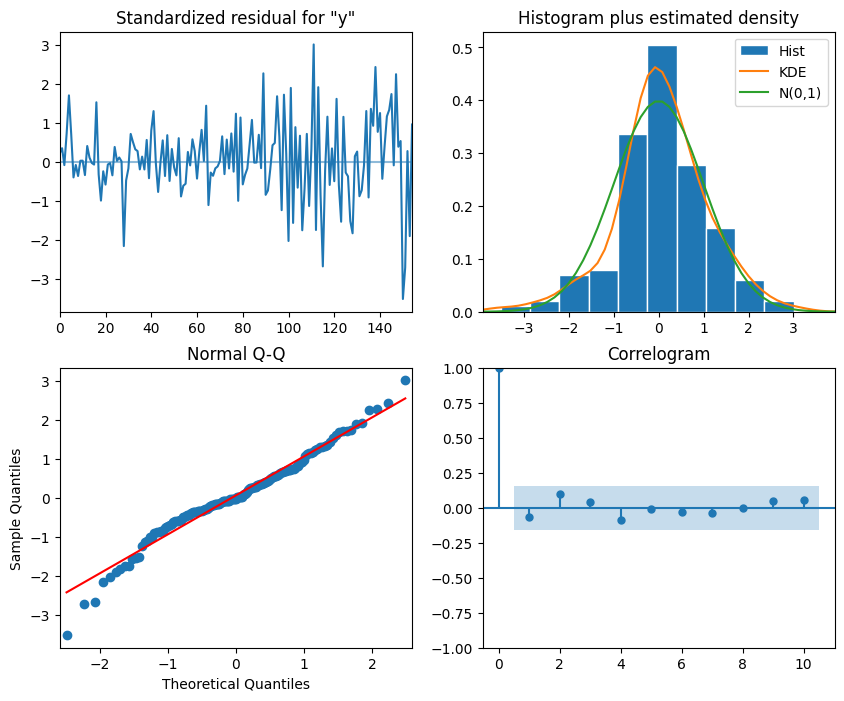

In [49]:
SARIMA_model = SARIMAX(train, order=(2,1,3),seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [50]:
residuals = SARIMA_model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(pvalue)

lb_pvalue


In [115]:
def rolling_forecast(df,train_len,pred_len,window,method='mean'):

    if method=='last_season':
        pred_last_season=[]
        for i in range(train_len,train_len+pred_len,window):
            data_last_season=df[i-window:i]['y'].values
            pred_last_season.extend(data_last_season)
        return pred_last_season
    if method=='mean':
        mean=[]
        for i in range(train_len,train_len+pred_len,window):
            data_mean=df[:i]['y'].mean()
            mean.extend(data_mean for _ in range(window))
        return mean
    if method=='last_season_mean':
        ls_mean=[]
        for i in range(train_len,train_len+pred_len,window):
            data_mean=df[i-window:i]['y'].mean()
            ls_mean.extend([data_mean for _ in range(window)])
        return ls_mean
    if method=='Sarima':
        sarima_pred=[]
        for i in range(train_len,train_len+pred_len,window):
            SARIMA_model = SARIMAX(df[:i]['y'], order=(2,0,3),seasonal_order=(1,1,3,12),
                                   simple_differencing=False)
            SARIMA_model_fit = SARIMA_model.fit(disp=False)
            predictions = SARIMA_model_fit.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            sarima_pred.extend(oos_pred)
        return sarima_pred

In [116]:
df_drug['last_season']=np.nan
df_drug['last_season_mean']=np.nan
df_drug['Sarima']=np.nan
df_drug['last_season'][-36:]=rolling_forecast(df_drug,len(train),len(test),window=12,method='last_season')
df_drug['last_season_mean'][-36:]=rolling_forecast(df_drug,len(train),len(test),window=12,method='last_season_mean')
df_drug['Sarima'][-36:]=rolling_forecast(df_drug,len(train),len(test),window=12,method='Sarima')

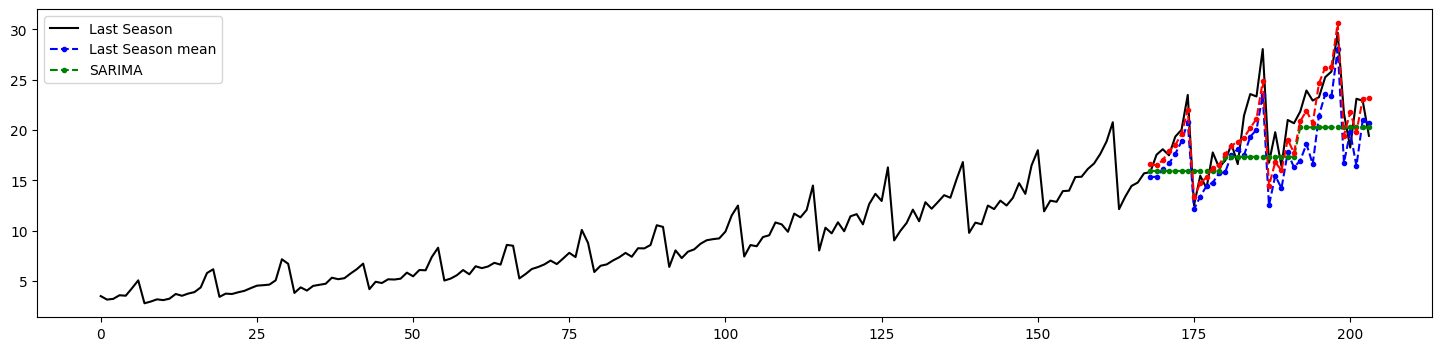

In [144]:
plt.figure(figsize=(18,4))
plt.plot(df_drug['y'],'k')
plt.plot(df_drug['last_season'],'b--.')
plt.plot(df_drug['last_season_mean'],'g--.')
plt.plot(df_drug['Sarima'],'r--.')
plt.legend(['Last Season','Last Season mean','SARIMA'])
plt.show()

In [149]:
mean_squared_error(df_drug['y'][-len(test):],df_drug['last_season'][-len(test):]),mean_squared_error(df_drug['y'][-len(test):],df_drug['last_season_mean'][-len(test):]),mean_squared_error(df_drug['y'][-len(test):],df_drug['Sarima'][-len(test):])

(9.94729181138971, 15.271886138357218, 3.6315202041382824)